In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set(style="whitegrid")
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.grid'] = True

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#from eli5.permutation_importance import get_score_importances as importances
import lightgbm as lgb

In [3]:
from bayes_opt import BayesianOptimization

In [4]:
def rmse(X, y): return np.sqrt(mean_squared_error(X,y))

def print_score(m):
    print('RMSE train: ',rmse(y_train, m.predict(X_train)))
    print('RMSE test: ',rmse(y_test, m.predict(X_test)))
    print('R2 train: ',r2_score(y_train, m.predict(X_train)))
    print('R2 test: ',r2_score(y_test, m.predict(X_test)))

# Strategia di test

#### In questo notebook si vuole fittare un modello ai dati, dal momento che le specifiche del progetto non parlano di un metodologia di testing specifica e dal momento che non mi è stato fornito un test set simulerò quello che potrebbe succedere nella realtà. 

#### Dal momento che abbiamo a che fare con variabili fisiche che variano nel tempo mi metto nella situazione reale in cui sarei testato su dati futuri non ancora misurati. Per simulare questa situazione la cosa ottimale da fare è quella di selezionare i dati più recenti del dataset a me fornitomi e utilizzarne una percentuale come datset di test. Per esempio posso assumere che l'istante di tempo attuale corrisponda al valore 7648 ovvero all'indice del valore corrispondente all'80% del dataset e che tutti i dati futuri non siano ancora stati misurati. Utilizzero quindi il primo 80% dei dati come dati di training e il restante 20% come dataset di test

# Strategia di validazione

#### Dal momento che i dati non hanno una dipendenza temporale e sono quindi dati iid  non occorre utilizzare una strategia di validazione necessaria se si ha a che fare con le serie temporali (Time Series K-fold Cross Validation tipica in ambito finanziario per effettuare il backtesting dei modelli). Utilizzerò' quindi la classica K-fold Cross Validation

# Metrica di valutazione

#### Dal momento che le specifiche del progetto non riportano una particolare metrica di valutazione per la valutazione delle predizioni dei modelli utilizzerò le metriche classiche di regressione come MSE, RMSE ed R^2, questo perchè ottimizzare le performance rispetto ad una di queste 3 metriche corrisponde ad ottimizzare le performances rispetto anche alle altre 2.

#### Non utilizzerò metriche come MAPE (Mean Absolute Percentage Error), sebbene metrica molto utilizzata sopratutto in ambito business, dal momento che per ottimizzare le performances rispetto a tale metrica dovrei riallenare i modelli pesando i dati inversamente rispetto al valore della target corrispondente in quanto tali metriche penalizzano maggiormente errori di predizione rispetto a valori bassi della target 

# Feature Engineering

#### Dal momento che il test non ha come obiettivo quello di ottenere le performance di predizioni migliori possibili, ma piuttosto ha come obiettivo quello di valutarci in  base ai nostri processi decisionali, valutazioni sull'importanza delle features e fase di modellizzazione, si è scelto di non effettuare feature engineering. 

# LightGBM training

In questo notebook allenerò due lightgbm, il primo verrà allenato con una tecnica di ottimizzazione dei parametri automatica che fa utilizzo della Bayesian Optimization

In [9]:
df = pd.read_csv('data/data02.csv', low_memory=False, index_col=0)

In [10]:
Y = df.pe.copy()
X = df.drop('pe',1)

In [11]:
# seed = 2
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [13]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size].copy(), X[train_size:len(X)].copy()
y_train, y_test = Y[0:train_size].copy(), Y[train_size:len(X)].copy()

## LightGBM allenato con Bayesian Optimization

In [14]:
def lgb_evaluate(min_data_in_leaf,
                     bagging_fraction,
                     feature_fraction,
                     num_leaves,
                     lambda_l2,
                     ):

        params['min_data_in_leaf'] = int(min_data_in_leaf)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['num_leaves'] = int(num_leaves)
        params['lambda_l2'] = max(lambda_l2, 0),




        cv_result = lgb.cv(nfold=5,params=params, metrics='l2',train_set=lgbtrain,stratified=False,
               num_boost_round=num_rounds,seed=random_state,#, early_stopping_rounds=10)
        callbacks=[lgb.callback.early_stopping(50)])
        #print(cv_result)
        return -(cv_result.get('l2-mean')[-1])


def prepare_data(X,y):
        _X = lgb.Dataset(X, label=y)

        return _X


lgbtrain = prepare_data(X_train,y_train)

num_rounds = 200
random_state = 0
num_iter = 50
init_points = 5
params = {
        'eta': 0.1,
        'silent': 1,
        'eval_metric': 'r2',
        'verbose_eval': True,
        'seed': random_state
    }

lgbBO = BayesianOptimization(lgb_evaluate, {'min_data_in_leaf': (4, 100),
                                                'bagging_fraction': (0.5, 1),
                                                'feature_fraction': (0.5, 1),
                                                'num_leaves': (4, 100),
                                                'lambda_l2': (0, 10),
                                                })

lgbBO.maximize(init_points=init_points, n_iter=num_iter)

|   iter    |  target   | baggin... | featur... | lambda_l2 | min_da... | num_le... |
-------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.


C:\Users\gabri_lavoro\Anaconda3\envs\tenaris\lib\site-packages\lightgbm\basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Did not meet early stopping. Best iteration is:
[200]	cv_agg's l2: 10.758 + 1.0289
|  1        | -10.76    |  0.6702   |  0.7743   |  3.277    |  30.08    |  52.78    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[200]	cv_agg's l2: 10.5705 + 0.933311
|  2        | -10.57    |  0.5257   |  0.9678   |  1.859    |  31.29    |  79.75    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[200]	cv_agg's l2: 12.3203 + 0.959386
|  3        | -12.32    |  0.9514   |  0.5097   |  1.722    |  46.01    |  75.86    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[200]	cv_agg's l2: 11.7571 + 1.11731
|  4        | -11.76    |  0.8134   |  0.8257   |  9.894    |  27.52    |  22.51    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[200]	cv_agg's l2: 1

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[199]	cv_agg's l2: 10.3735 + 0.994291
|  30       | -10.37    |  0.5      |  1.0      |  10.0     |  29.49    |  76.52    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[199]	cv_agg's l2: 10.2225 + 0.965266
|  31       | -10.22    |  0.5      |  1.0      |  10.0     |  5.471    |  68.42    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[195]	cv_agg's l2: 10.0997 + 0.946472
|  32       | -10.1     |  0.5      |  1.0      |  10.0     |  12.19    |  96.69    |
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[200]	cv_agg's l2: 10.1903 + 0.932308
|  33       | -10.19    |  0.5      |  1.0      |  10.0     |  23.93    |  100.0    |
Training until validation scores don't improve for 50 rounds.
Di

In [15]:
params = lgbBO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params

{'bagging_fraction': 1.0,
 'feature_fraction': 1.0,
 'lambda_l2': 0.0,
 'min_data_in_leaf': 8,
 'num_leaves': 86}

In [16]:
lgb1 = lgb.train(params=params,train_set=lgbtrain)

In [17]:
print_score(lgb1)

RMSE train:  2.0389880142465966
RMSE test:  3.0184075356881372
R2 train:  0.9856095795130398
R2 test:  0.9697257373538808


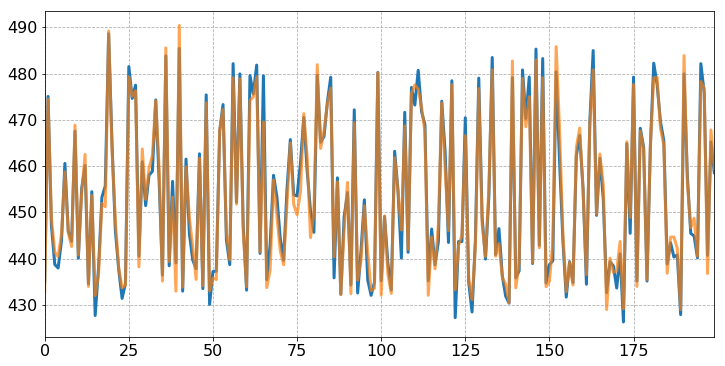

In [18]:
import matplotlib.pyplot as plt 
%matplotlib inline
fig=plt.figure(figsize=(12,6))

y_test[:200].reset_index(drop=True).plot(linewidth=3,fontsize=16)
plt.plot(lgb1.predict(X_test[:200]),linewidth=3,alpha=0.7)

In [19]:
from joblib import dump,load
import os

directory='models'

if not os.path.exists(directory):
    os.makedirs(directory)

dump(lgb1, 'models/LightGBM1.joblib') 

['models/LightGBM1.joblib']

## LightGBM allenato mediante training incrementale

In [81]:
df = pd.read_csv('data/data02.csv', low_memory=False, index_col=0)
Y = df.pe.copy()
X = df.drop('pe',1)
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size].copy(), X[train_size:len(X)].copy()
y_train, y_test = Y[0:train_size].copy(), Y[train_size:len(X)].copy()

In [82]:
feat_name = [n for n in df.columns if n!='pe']

In [83]:
train_size = int(len(X_train) * 0.95)
y_train, y_valid = y_train[0:train_size], y_train[train_size:len(X_train)]
X_train, X_valid = X_train[0:train_size], X_train[train_size:len(X_train)]

[1]	valid_0's l2: 247.884
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 225.372
[3]	valid_0's l2: 205.271
[4]	valid_0's l2: 187.007
[5]	valid_0's l2: 170.541
[6]	valid_0's l2: 155.741
[7]	valid_0's l2: 142.381
[8]	valid_0's l2: 130.359
[9]	valid_0's l2: 119.477
[10]	valid_0's l2: 109.551
[11]	valid_0's l2: 100.635
[12]	valid_0's l2: 92.6234
[13]	valid_0's l2: 85.3457
[14]	valid_0's l2: 78.7812
[15]	valid_0's l2: 72.762
[16]	valid_0's l2: 67.4037
[17]	valid_0's l2: 62.5826
[18]	valid_0's l2: 58.2369
[19]	valid_0's l2: 54.2679
[20]	valid_0's l2: 50.7034
[21]	valid_0's l2: 47.403
[22]	valid_0's l2: 44.4798
[23]	valid_0's l2: 41.8503
[24]	valid_0's l2: 39.4741
[25]	valid_0's l2: 37.2108
[26]	valid_0's l2: 35.1873
[27]	valid_0's l2: 33.479
[28]	valid_0's l2: 31.7911
[29]	valid_0's l2: 30.3027
[30]	valid_0's l2: 28.9786
[31]	valid_0's l2: 27.7319
[32]	valid_0's l2: 26.6801
[33]	valid_0's l2: 25.6774
[34]	valid_0's l2: 24.8492
[35]	valid_0's l2: 24.0276
[36]

[307]	valid_0's l2: 11.209
[308]	valid_0's l2: 11.2018
[309]	valid_0's l2: 11.1977
[310]	valid_0's l2: 11.1816
[311]	valid_0's l2: 11.1783
[312]	valid_0's l2: 11.1504
[313]	valid_0's l2: 11.1484
[314]	valid_0's l2: 11.1458
[315]	valid_0's l2: 11.1379
[316]	valid_0's l2: 11.1299
[317]	valid_0's l2: 11.1294
[318]	valid_0's l2: 11.1318
[319]	valid_0's l2: 11.1216
[320]	valid_0's l2: 11.0968
[321]	valid_0's l2: 11.0964
[322]	valid_0's l2: 11.0936
[323]	valid_0's l2: 11.0899
[324]	valid_0's l2: 11.0805
[325]	valid_0's l2: 11.0786
[326]	valid_0's l2: 11.0696
[327]	valid_0's l2: 11.0579
[328]	valid_0's l2: 11.0492
[329]	valid_0's l2: 11.0426
[330]	valid_0's l2: 11.0289
[331]	valid_0's l2: 11.0194
[332]	valid_0's l2: 11.0096
[333]	valid_0's l2: 11.0044
[334]	valid_0's l2: 11.0083
[335]	valid_0's l2: 11.0002
[336]	valid_0's l2: 10.9993
[337]	valid_0's l2: 10.9922
[338]	valid_0's l2: 10.9874
[339]	valid_0's l2: 10.968
[340]	valid_0's l2: 10.9687
[341]	valid_0's l2: 10.9663
[342]	valid_0's l2: 10

[652]	valid_0's l2: 10.0987
[653]	valid_0's l2: 10.1024
[654]	valid_0's l2: 10.1083
[655]	valid_0's l2: 10.11
[656]	valid_0's l2: 10.1023
[657]	valid_0's l2: 10.1074
[658]	valid_0's l2: 10.1066
[659]	valid_0's l2: 10.1081
[660]	valid_0's l2: 10.1052
[661]	valid_0's l2: 10.1053
[662]	valid_0's l2: 10.1075
[663]	valid_0's l2: 10.1121
[664]	valid_0's l2: 10.1096
[665]	valid_0's l2: 10.1081
[666]	valid_0's l2: 10.1136
[667]	valid_0's l2: 10.1145
[668]	valid_0's l2: 10.1182
[669]	valid_0's l2: 10.1158
[670]	valid_0's l2: 10.1162
[671]	valid_0's l2: 10.113
[672]	valid_0's l2: 10.1148
[673]	valid_0's l2: 10.1066
[674]	valid_0's l2: 10.1095
[675]	valid_0's l2: 10.1107
[676]	valid_0's l2: 10.1107
[677]	valid_0's l2: 10.1092
[678]	valid_0's l2: 10.106
[679]	valid_0's l2: 10.101
[680]	valid_0's l2: 10.1017
[681]	valid_0's l2: 10.0985
[682]	valid_0's l2: 10.089
[683]	valid_0's l2: 10.0835
[684]	valid_0's l2: 10.0784
[685]	valid_0's l2: 10.0793
[686]	valid_0's l2: 10.0761
[687]	valid_0's l2: 10.075

[997]	valid_0's l2: 9.73842
[998]	valid_0's l2: 9.73629
[999]	valid_0's l2: 9.73617
[1000]	valid_0's l2: 9.74074
[1001]	valid_0's l2: 9.74007
[1002]	valid_0's l2: 9.73929
[1003]	valid_0's l2: 9.74196
[1004]	valid_0's l2: 9.74031
[1005]	valid_0's l2: 9.73918
[1006]	valid_0's l2: 9.73983
[1007]	valid_0's l2: 9.73948
[1008]	valid_0's l2: 9.74036
[1009]	valid_0's l2: 9.74551
[1010]	valid_0's l2: 9.74172
[1011]	valid_0's l2: 9.74508
[1012]	valid_0's l2: 9.73889
[1013]	valid_0's l2: 9.73473
[1014]	valid_0's l2: 9.73851
[1015]	valid_0's l2: 9.73818
[1016]	valid_0's l2: 9.73673
[1017]	valid_0's l2: 9.73496
[1018]	valid_0's l2: 9.7332
[1019]	valid_0's l2: 9.73543
[1020]	valid_0's l2: 9.73554
[1021]	valid_0's l2: 9.73606
[1022]	valid_0's l2: 9.73459
[1023]	valid_0's l2: 9.73542
[1024]	valid_0's l2: 9.73723
[1025]	valid_0's l2: 9.73583
[1026]	valid_0's l2: 9.73636
[1027]	valid_0's l2: 9.73684
[1028]	valid_0's l2: 9.73965
[1029]	valid_0's l2: 9.743
[1030]	valid_0's l2: 9.74148
[1031]	valid_0's l2:

[1341]	valid_0's l2: 9.63273
[1342]	valid_0's l2: 9.63028
[1343]	valid_0's l2: 9.63209
[1344]	valid_0's l2: 9.63053
[1345]	valid_0's l2: 9.62603
[1346]	valid_0's l2: 9.62608
[1347]	valid_0's l2: 9.62692
[1348]	valid_0's l2: 9.62467
[1349]	valid_0's l2: 9.62619
[1350]	valid_0's l2: 9.628
[1351]	valid_0's l2: 9.627
[1352]	valid_0's l2: 9.62957
[1353]	valid_0's l2: 9.62914
[1354]	valid_0's l2: 9.62977
[1355]	valid_0's l2: 9.62944
[1356]	valid_0's l2: 9.63095
[1357]	valid_0's l2: 9.63219
[1358]	valid_0's l2: 9.63114
[1359]	valid_0's l2: 9.63048
[1360]	valid_0's l2: 9.63057
[1361]	valid_0's l2: 9.62782
[1362]	valid_0's l2: 9.63002
[1363]	valid_0's l2: 9.63315
Early stopping, best iteration is:
[1263]	valid_0's l2: 9.59103
R2 train:  0.9895950674136971
R2 test:  0.9700637435947687
[1264]	valid_0's l2: 9.59501
Training until validation scores don't improve for 100 rounds.
[1265]	valid_0's l2: 9.59651
[1266]	valid_0's l2: 9.59528
[1267]	valid_0's l2: 9.59321
[1268]	valid_0's l2: 9.59494
[1269]

C:\Users\gabri_lavoro\Anaconda3\envs\tenaris\lib\site-packages\lightgbm\basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")
C:\Users\gabri_lavoro\Anaconda3\envs\tenaris\lib\site-packages\lightgbm\basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")



[1387]	valid_0's l2: 9.55616
[1388]	valid_0's l2: 9.55903
[1389]	valid_0's l2: 9.55761
[1390]	valid_0's l2: 9.55749
[1391]	valid_0's l2: 9.55714
[1392]	valid_0's l2: 9.55887
[1393]	valid_0's l2: 9.55008
[1394]	valid_0's l2: 9.55315
[1395]	valid_0's l2: 9.55638
[1396]	valid_0's l2: 9.54937
[1397]	valid_0's l2: 9.55038
[1398]	valid_0's l2: 9.55244
[1399]	valid_0's l2: 9.55411
[1400]	valid_0's l2: 9.55549
[1401]	valid_0's l2: 9.55782
[1402]	valid_0's l2: 9.55845
[1403]	valid_0's l2: 9.55886
[1404]	valid_0's l2: 9.56252
[1405]	valid_0's l2: 9.56198
[1406]	valid_0's l2: 9.5665
[1407]	valid_0's l2: 9.56397
[1408]	valid_0's l2: 9.56621
[1409]	valid_0's l2: 9.56569
[1410]	valid_0's l2: 9.56288
[1411]	valid_0's l2: 9.55988
[1412]	valid_0's l2: 9.55987
[1413]	valid_0's l2: 9.56165
[1414]	valid_0's l2: 9.55954
[1415]	valid_0's l2: 9.55789
[1416]	valid_0's l2: 9.55719
[1417]	valid_0's l2: 9.55205
[1418]	valid_0's l2: 9.55499
[1419]	valid_0's l2: 9.56063
[1420]	valid_0's l2: 9.56437
[1421]	valid_0

[1699]	valid_0's l2: 9.47997
[1700]	valid_0's l2: 9.47746
[1701]	valid_0's l2: 9.47625
[1702]	valid_0's l2: 9.47991
[1703]	valid_0's l2: 9.48214
[1704]	valid_0's l2: 9.48422
[1705]	valid_0's l2: 9.48459
[1706]	valid_0's l2: 9.48342
[1707]	valid_0's l2: 9.48666
[1708]	valid_0's l2: 9.48543
[1709]	valid_0's l2: 9.48566
[1710]	valid_0's l2: 9.48297
[1711]	valid_0's l2: 9.48078
[1712]	valid_0's l2: 9.47945
[1713]	valid_0's l2: 9.48116
[1714]	valid_0's l2: 9.47492
[1715]	valid_0's l2: 9.47506
[1716]	valid_0's l2: 9.47588
[1717]	valid_0's l2: 9.47761
[1718]	valid_0's l2: 9.4764
[1719]	valid_0's l2: 9.47995
[1720]	valid_0's l2: 9.47857
[1721]	valid_0's l2: 9.47836
[1722]	valid_0's l2: 9.48004
[1723]	valid_0's l2: 9.48439
[1724]	valid_0's l2: 9.48149
[1725]	valid_0's l2: 9.48109
[1726]	valid_0's l2: 9.48276
[1727]	valid_0's l2: 9.4808
[1728]	valid_0's l2: 9.48159
[1729]	valid_0's l2: 9.48186
[1730]	valid_0's l2: 9.48186
[1731]	valid_0's l2: 9.48367
[1732]	valid_0's l2: 9.48701
[1733]	valid_0's

C:\Users\gabri_lavoro\Anaconda3\envs\tenaris\lib\site-packages\lightgbm\basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")
C:\Users\gabri_lavoro\Anaconda3\envs\tenaris\lib\site-packages\lightgbm\basic.py:814: UserWarning: The prediction of init_model will be overridden by init_score.
  warnings.warn("The prediction of init_model will be overridden by init_score.")



[1763]	valid_0's l2: 9.54024
[1764]	valid_0's l2: 9.54103
[1765]	valid_0's l2: 9.54083
[1766]	valid_0's l2: 9.54428
[1767]	valid_0's l2: 9.54574
[1768]	valid_0's l2: 9.54883
[1769]	valid_0's l2: 9.54974
[1770]	valid_0's l2: 9.55204
[1771]	valid_0's l2: 9.5519
[1772]	valid_0's l2: 9.55731
[1773]	valid_0's l2: 9.55583
[1774]	valid_0's l2: 9.5551
[1775]	valid_0's l2: 9.55614
[1776]	valid_0's l2: 9.55878
[1777]	valid_0's l2: 9.55681
[1778]	valid_0's l2: 9.55774
[1779]	valid_0's l2: 9.55627
[1780]	valid_0's l2: 9.55834
[1781]	valid_0's l2: 9.55776
[1782]	valid_0's l2: 9.55769
[1783]	valid_0's l2: 9.56147
[1784]	valid_0's l2: 9.56075
[1785]	valid_0's l2: 9.56079
[1786]	valid_0's l2: 9.56235
[1787]	valid_0's l2: 9.56127
[1788]	valid_0's l2: 9.56188
[1789]	valid_0's l2: 9.55724
[1790]	valid_0's l2: 9.55597
[1791]	valid_0's l2: 9.55513
[1792]	valid_0's l2: 9.5548
[1793]	valid_0's l2: 9.5553
[1794]	valid_0's l2: 9.55482
[1795]	valid_0's l2: 9.55624
[1796]	valid_0's l2: 9.55471
[1797]	valid_0's 

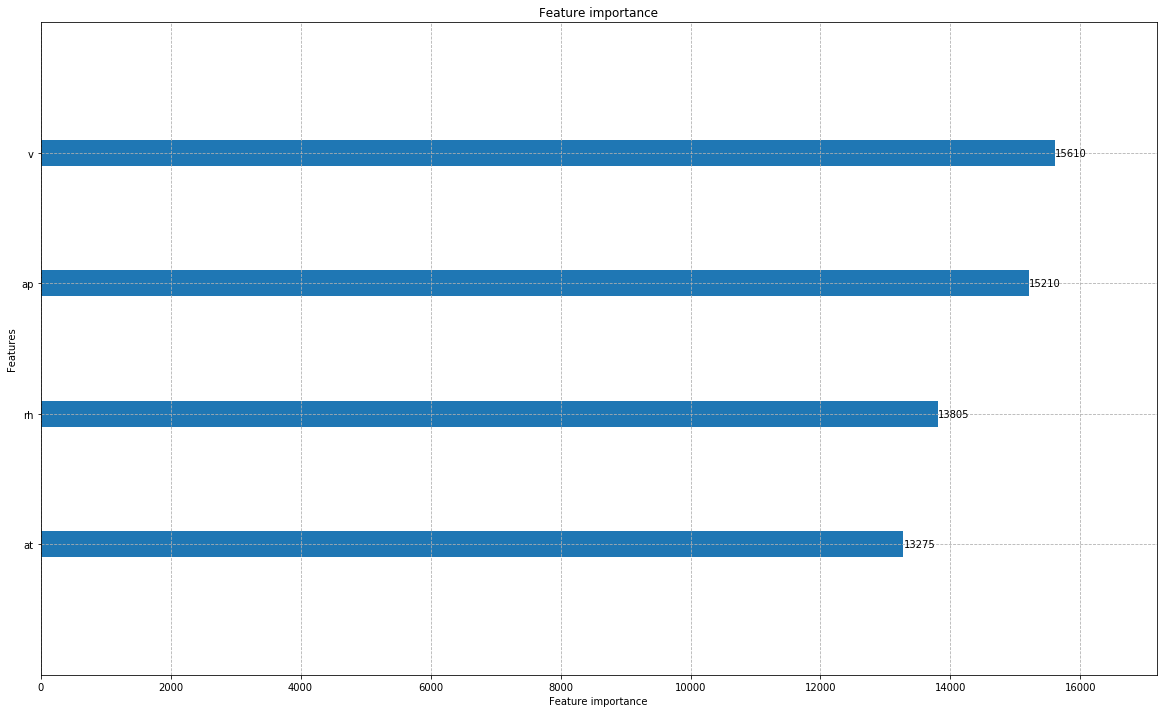

In [84]:
train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid = lgb.Dataset(X_valid, label=y_valid, reference=train, free_raw_data=False)

#
# Train the model
#

parameters = {
    'application': 'train',
    'objective': 'regression',
    'metric': 'mse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       train,
                       valid_sets=valid,
                       num_boost_round=50000,
                       early_stopping_rounds=100,
                       feature_name=feat_name
                       )

print('R2 train: ', r2_score(y_train, model.predict(X_train)))

print('R2 test: ', r2_score(y_test, model.predict(X_test)))


model = lgb.train(parameters,
                train,
                num_boost_round=50000,
                init_model=model,
                learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                valid_sets=valid,
                feature_name=feat_name,
                
                       early_stopping_rounds=100)


print('R2 train: ', r2_score(y_train, model.predict(X_train)))

print('R2 test: ', r2_score(y_test, model.predict(X_test)))

model = lgb.train(parameters,
                train,
                num_boost_round=50000,
                init_model=model,
                valid_sets=valid,
                callbacks=[lgb.reset_parameter(bagging_fraction=[0.9] * 10000 + [0.8] * 10000 + [0.7] * 10000 +[0.6] * 20000)],
                feature_name=feat_name,
                
                       early_stopping_rounds=100)

print('R2 train: ', r2_score(y_train, model.predict(X_train)))

print('R2 test: ', r2_score(y_test, model.predict(X_test)))


lgb2 = lgb.train(parameters,
                train,
                num_boost_round=50000,
                init_model=model,
                valid_sets=valid,
                callbacks=[lgb.reset_parameter(feature_fraction=[0.9] * 10000 + [0.8] * 10000 + [0.7] * 10000 +[0.6] * 20000)],
                feature_name=feat_name,
                
                       early_stopping_rounds=100)

print('R2 train: ', r2_score(y_train, lgb2.predict(X_train)))

print('R2 test: ', r2_score(y_test, lgb2.predict(X_test)))


ax = lgb.plot_importance(lgb2, max_num_features=30,figsize=(20,12))
lgb2.feature_importance()
plt.show()

In [85]:
print_score(lgb2)

RMSE train:  1.405651383475153
RMSE test:  3.035492918120927
R2 train:  0.993181152589274
R2 test:  0.9693820387237131


In [86]:
train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid = lgb.Dataset(X_valid, label=y_valid, reference=train, free_raw_data=False)

#
# Train the model
#

parameters = {
    'application': 'train',
    'objective': 'regression',
    'metric': 'mse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       train,
                       valid_sets=valid,
                       num_boost_round=50000,
                       early_stopping_rounds=100,
                       feature_name=feat_name
                       )

print('R2 train: ', r2_score(y_train, model.predict(X_train)))

print('R2 test: ', r2_score(y_test, model.predict(X_test)))


lgb2 = lgb.train(parameters,
                train,
                num_boost_round=50000,
                init_model=model,
                learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                valid_sets=valid,
                feature_name=feat_name,
                
                       early_stopping_rounds=100)

print('R2 train: ', r2_score(y_train, lgb2.predict(X_train)))

print('R2 test: ', r2_score(y_test, lgb2.predict(X_test)))

[1]	valid_0's l2: 247.884
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 225.372
[3]	valid_0's l2: 205.271
[4]	valid_0's l2: 187.007
[5]	valid_0's l2: 170.541
[6]	valid_0's l2: 155.741
[7]	valid_0's l2: 142.381
[8]	valid_0's l2: 130.359
[9]	valid_0's l2: 119.477
[10]	valid_0's l2: 109.551
[11]	valid_0's l2: 100.635
[12]	valid_0's l2: 92.6234
[13]	valid_0's l2: 85.3457
[14]	valid_0's l2: 78.7812
[15]	valid_0's l2: 72.762
[16]	valid_0's l2: 67.4037
[17]	valid_0's l2: 62.5826
[18]	valid_0's l2: 58.2369
[19]	valid_0's l2: 54.2679
[20]	valid_0's l2: 50.7034
[21]	valid_0's l2: 47.403
[22]	valid_0's l2: 44.4798
[23]	valid_0's l2: 41.8503
[24]	valid_0's l2: 39.4741
[25]	valid_0's l2: 37.2108
[26]	valid_0's l2: 35.1873
[27]	valid_0's l2: 33.479
[28]	valid_0's l2: 31.7911
[29]	valid_0's l2: 30.3027
[30]	valid_0's l2: 28.9786
[31]	valid_0's l2: 27.7319
[32]	valid_0's l2: 26.6801
[33]	valid_0's l2: 25.6774
[34]	valid_0's l2: 24.8492
[35]	valid_0's l2: 24.0276
[36]

[309]	valid_0's l2: 11.1977
[310]	valid_0's l2: 11.1816
[311]	valid_0's l2: 11.1783
[312]	valid_0's l2: 11.1504
[313]	valid_0's l2: 11.1484
[314]	valid_0's l2: 11.1458
[315]	valid_0's l2: 11.1379
[316]	valid_0's l2: 11.1299
[317]	valid_0's l2: 11.1294
[318]	valid_0's l2: 11.1318
[319]	valid_0's l2: 11.1216
[320]	valid_0's l2: 11.0968
[321]	valid_0's l2: 11.0964
[322]	valid_0's l2: 11.0936
[323]	valid_0's l2: 11.0899
[324]	valid_0's l2: 11.0805
[325]	valid_0's l2: 11.0786
[326]	valid_0's l2: 11.0696
[327]	valid_0's l2: 11.0579
[328]	valid_0's l2: 11.0492
[329]	valid_0's l2: 11.0426
[330]	valid_0's l2: 11.0289
[331]	valid_0's l2: 11.0194
[332]	valid_0's l2: 11.0096
[333]	valid_0's l2: 11.0044
[334]	valid_0's l2: 11.0083
[335]	valid_0's l2: 11.0002
[336]	valid_0's l2: 10.9993
[337]	valid_0's l2: 10.9922
[338]	valid_0's l2: 10.9874
[339]	valid_0's l2: 10.968
[340]	valid_0's l2: 10.9687
[341]	valid_0's l2: 10.9663
[342]	valid_0's l2: 10.9511
[343]	valid_0's l2: 10.9396
[344]	valid_0's l2: 1

[727]	valid_0's l2: 10.0138
[728]	valid_0's l2: 10.0065
[729]	valid_0's l2: 10.0063
[730]	valid_0's l2: 10.0056
[731]	valid_0's l2: 10.0003
[732]	valid_0's l2: 10.0032
[733]	valid_0's l2: 10.0057
[734]	valid_0's l2: 10.0062
[735]	valid_0's l2: 9.99701
[736]	valid_0's l2: 9.99194
[737]	valid_0's l2: 9.98664
[738]	valid_0's l2: 9.98126
[739]	valid_0's l2: 9.98217
[740]	valid_0's l2: 9.98413
[741]	valid_0's l2: 9.98675
[742]	valid_0's l2: 9.98411
[743]	valid_0's l2: 9.97432
[744]	valid_0's l2: 9.9754
[745]	valid_0's l2: 9.97138
[746]	valid_0's l2: 9.97085
[747]	valid_0's l2: 9.97064
[748]	valid_0's l2: 9.97101
[749]	valid_0's l2: 9.9659
[750]	valid_0's l2: 9.97295
[751]	valid_0's l2: 9.97217
[752]	valid_0's l2: 9.96794
[753]	valid_0's l2: 9.9637
[754]	valid_0's l2: 9.9628
[755]	valid_0's l2: 9.95796
[756]	valid_0's l2: 9.95985
[757]	valid_0's l2: 9.95862
[758]	valid_0's l2: 9.95646
[759]	valid_0's l2: 9.95744
[760]	valid_0's l2: 9.9555
[761]	valid_0's l2: 9.95829
[762]	valid_0's l2: 9.957

[1048]	valid_0's l2: 9.73068
[1049]	valid_0's l2: 9.73425
[1050]	valid_0's l2: 9.73481
[1051]	valid_0's l2: 9.73582
[1052]	valid_0's l2: 9.73276
[1053]	valid_0's l2: 9.72968
[1054]	valid_0's l2: 9.7233
[1055]	valid_0's l2: 9.71531
[1056]	valid_0's l2: 9.71731
[1057]	valid_0's l2: 9.72052
[1058]	valid_0's l2: 9.72035
[1059]	valid_0's l2: 9.71937
[1060]	valid_0's l2: 9.7142
[1061]	valid_0's l2: 9.71339
[1062]	valid_0's l2: 9.71152
[1063]	valid_0's l2: 9.70825
[1064]	valid_0's l2: 9.71055
[1065]	valid_0's l2: 9.71015
[1066]	valid_0's l2: 9.71117
[1067]	valid_0's l2: 9.71214
[1068]	valid_0's l2: 9.71241
[1069]	valid_0's l2: 9.71211
[1070]	valid_0's l2: 9.71177
[1071]	valid_0's l2: 9.71349
[1072]	valid_0's l2: 9.71234
[1073]	valid_0's l2: 9.71184
[1074]	valid_0's l2: 9.7039
[1075]	valid_0's l2: 9.70546
[1076]	valid_0's l2: 9.70866
[1077]	valid_0's l2: 9.7052
[1078]	valid_0's l2: 9.70716
[1079]	valid_0's l2: 9.70703
[1080]	valid_0's l2: 9.70601
[1081]	valid_0's l2: 9.7065
[1082]	valid_0's l2

R2 train:  0.9895950674136971
R2 test:  0.9700637435947687
[1264]	valid_0's l2: 9.59501
Training until validation scores don't improve for 100 rounds.
[1265]	valid_0's l2: 9.59651
[1266]	valid_0's l2: 9.59528
[1267]	valid_0's l2: 9.59321
[1268]	valid_0's l2: 9.59494
[1269]	valid_0's l2: 9.59223
[1270]	valid_0's l2: 9.59156
[1271]	valid_0's l2: 9.59454
[1272]	valid_0's l2: 9.59282
[1273]	valid_0's l2: 9.59287
[1274]	valid_0's l2: 9.59429
[1275]	valid_0's l2: 9.5919
[1276]	valid_0's l2: 9.59248
[1277]	valid_0's l2: 9.59091
[1278]	valid_0's l2: 9.59502
[1279]	valid_0's l2: 9.59505
[1280]	valid_0's l2: 9.59679
[1281]	valid_0's l2: 9.60018
[1282]	valid_0's l2: 9.60145
[1283]	valid_0's l2: 9.60062
[1284]	valid_0's l2: 9.60584
[1285]	valid_0's l2: 9.60493
[1286]	valid_0's l2: 9.60767
[1287]	valid_0's l2: 9.61039
[1288]	valid_0's l2: 9.61188
[1289]	valid_0's l2: 9.61068
[1290]	valid_0's l2: 9.60764
[1291]	valid_0's l2: 9.60714
[1292]	valid_0's l2: 9.60646
[1293]	valid_0's l2: 9.60944
[1294]	va

In [87]:
print_score(model)

RMSE train:  1.736368000798317
RMSE test:  3.00151027377677
R2 train:  0.9895950674136971
R2 test:  0.9700637435947687


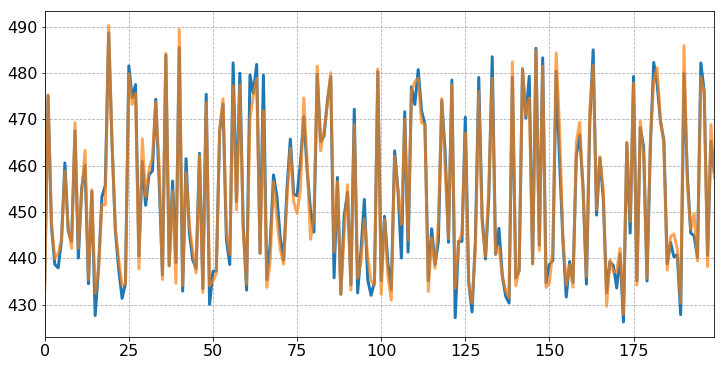

In [89]:
fig=plt.figure(figsize=(12,6))

y_test[:200].reset_index(drop=True).plot(linewidth=3,fontsize=16)
plt.plot(lgb2.predict(X_test[:200]),linewidth=3,alpha=0.7)

In [88]:
from joblib import dump,load
import os

directory='models'

if not os.path.exists(directory):
    os.makedirs(directory)

dump(lgb2, 'models/LightGBM2.joblib') 

['models/LightGBM2.joblib']

####  Con il metodo di training incrementale si ottiene il miglior modello in termini di performances sul test set con un RMSE di test di 3.00 ed un R2 di test di 0.97

#### Nel prossimo notebook utilizzeremo tecniche di ensembling quali lo stacking e il bagging per cercare di aumentare ulteriormente le performances